File to train the deep learning model on new data

In [1]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode 

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import os
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
import random

In [3]:
def cv2_imshow(im, rgb=False):
    if rgb:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off')

In [4]:
image_training_dir = "Images/pool_dataset_extended/training/images/"
image_testing_dir = "Images/pool_dataset_extended/testing/images/"
annotation_training_dir = "Images/pool_dataset_extended/training/labels/"
annotation_testing_dir = "Images/pool_dataset_extended/testing/labels/"
annotation_training_files = ["000002764.xml", "000002041.xml", "000000186.xml"]

In [5]:
# Parse XML file
def parse_xml(img_dir, file, index):
    tree = ET.parse(file)
    root = tree.getroot()

    file_dict = {}

    file_dict["file_name"] = os.path.join(img_dir.replace('labels', 'images'), root.find('filename').text)
    file_dict["height"] = int(root.find("size/height").text)
    file_dict["width"] = int(root.find("size/width").text)
    file_dict["image_id"] = index

    list_with_all_boxes = []
    for boxes in root.iter('object'):
        
        
        ymin, xmin, ymax, xmax = None, None, None, None
        
        ymin = round(float(boxes.find("bndbox/ymin").text))
        xmin = round(float(boxes.find("bndbox/xmin").text))
        ymax = round(float(boxes.find("bndbox/ymax").text))
        xmax = round(float(boxes.find("bndbox/xmax").text))

        obj = {
            "bbox": [xmin, ymin, xmax, ymax],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": 0,
        }
        list_with_all_boxes.append(obj)
    file_dict["annotations"] = list_with_all_boxes
    return file_dict

def parse_dir_xml(annotation_folder):
    fichiers = [f for f in os.listdir(annotation_folder) if os.path.isfile(os.path.join(annotation_folder, f))]
    dataset_dicts = []
    index = 0

    for data in fichiers:
        record = parse_xml(annotation_folder ,os.path.join(annotation_folder, data), index)
        dataset_dicts.append(record)
        index += 1
    return dataset_dicts

# Visualize image with bounding boxes
def visualize_image(image_folder, annotation_folder, annotation_file):
    data = parse_xml(annotation_folder, os.path.join(annotation_folder, annotation_file), 0)

    img = cv2.imread(data["file_name"])

    for box in data["annotations"]:
        cv2.rectangle(img, (box["bbox"][0], box["bbox"][1]), (box["bbox"][2], box["bbox"][3]), (0, 255, 0), 2)
    
    cv2_imshow(img, True)

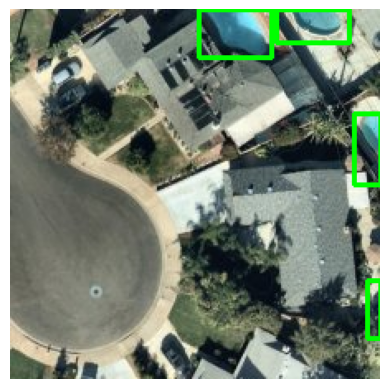

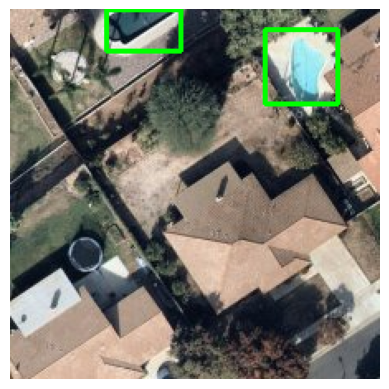

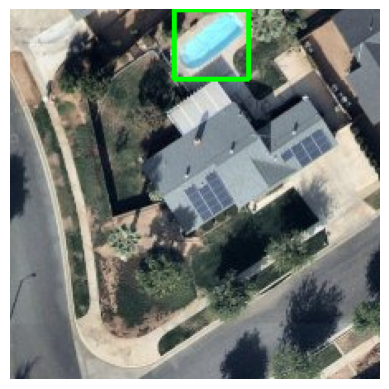

In [6]:
for ann_file in annotation_training_files:
    visualize_image(image_training_dir, annotation_training_dir, ann_file)

In [7]:
for d in ["training", "testing"]:
    DatasetCatalog.register("pool_" + d, lambda d=d: parse_dir_xml("Images/pool_dataset_extended/" + d + "/labels/"))
    MetadataCatalog.get("pool_" + d).set(thing_classes=["pool"])

pool_metadata = MetadataCatalog.get("pool_training")

In [8]:
DatasetCatalog.get("pool_testing")

[{'file_name': 'Images/pool_dataset_extended/testing/images/000000698.jpg',
  'height': 224,
  'width': 224,
  'image_id': 0,
  'annotations': [{'bbox': [210, 204, 223, 224],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}]},
 {'file_name': 'Images/pool_dataset_extended/testing/images/000000524.jpg',
  'height': 224,
  'width': 224,
  'image_id': 1,
  'annotations': [{'bbox': [77, 191, 128, 214],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}]},
 {'file_name': 'Images/pool_dataset_extended/testing/images/image_cannes_x0_y31.jpg',
  'height': 224,
  'width': 224,
  'image_id': 2,
  'annotations': []},
 {'file_name': 'Images/pool_dataset_extended/testing/images/000000084.jpg',
  'height': 224,
  'width': 224,
  'image_id': 3,
  'annotations': [{'bbox': [1, 182, 20, 220],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}]},
 {'file_name': 'Images/pool_dataset_extended/testing/images/image_cannes_x1_y40.jpg',
  'height': 224,
  'width': 224,
  'imag

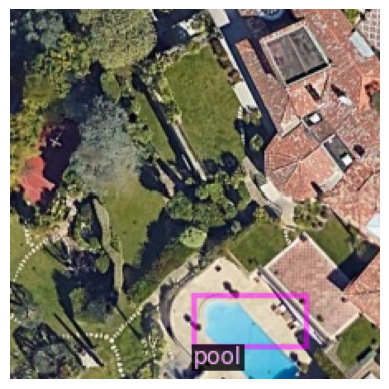

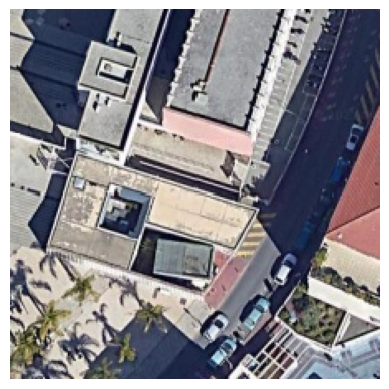

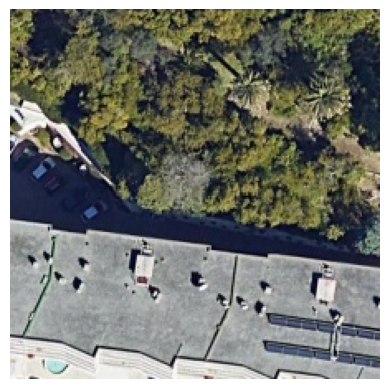

In [9]:
dataset_dicts = parse_dir_xml(annotation_training_dir)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=pool_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1], True)

In [10]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.MODEL.DEVICE = "cuda"

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml"))
cfg.DATASETS.TRAIN = ("pool_training")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.002  # pick a good LR
cfg.SOLVER.MAX_ITER = 600    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/17 13:22:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[11/17 13:22:32 d2.engine.train_loop]: Starting training from iteration 0


/home/loicchamberlin/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/17 13:22:45 d2.utils.events]:  eta: 0:05:34  iter: 19  total_loss: 0.9264  loss_cls: 0.6879  loss_box_reg: 0.105  loss_rpn_cls: 0.1324  loss_rpn_loc: 0.007746    time: 0.5818  last_time: 0.4768  data_time: 0.0106  last_data_time: 0.0067   lr: 6.527e-05  max_mem: 4678M
[11/17 13:22:56 d2.utils.events]:  eta: 0:05:21  iter: 39  total_loss: 0.3273  loss_cls: 0.1726  loss_box_reg: 0.0776  loss_rpn_cls: 0.09101  loss_rpn_loc: 0.008215    time: 0.5752  last_time: 0.5514  data_time: 0.0072  last_data_time: 0.0077   lr: 0.00013187  max_mem: 4678M
[11/17 13:23:07 d2.utils.events]:  eta: 0:05:04  iter: 59  total_loss: 0.2827  loss_cls: 0.1068  loss_box_reg: 0.08923  loss_rpn_cls: 0.06269  loss_rpn_loc: 0.008688    time: 0.5576  last_time: 0.5658  data_time: 0.0078  last_data_time: 0.0088   lr: 0.00019847  max_mem: 4678M
[11/17 13:23:17 d2.utils.events]:  eta: 0:04:43  iter: 79  total_loss: 0.269  loss_cls: 0.1066  loss_box_reg: 0.1087  loss_rpn_cls: 0.04293  loss_rpn_loc: 0.008429    time: 0

In [11]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Reusing TensorBoard on port 6006 (pid 9122), started 3 days, 1:38:09 ago. (Use '!kill 9122' to kill it.)

In [12]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold

predictor = DefaultPredictor(cfg)

[11/17 13:27:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


Images/pool_dataset_extended/testing/images/000001076.jpg
Images/pool_dataset_extended/testing/images/000000322.jpg
Images/pool_dataset_extended/testing/images/image_cannes_x1_y23.jpg
Images/pool_dataset_extended/testing/images/image_arcachon_x1_y20.jpg


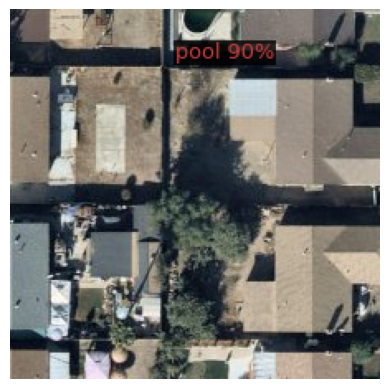

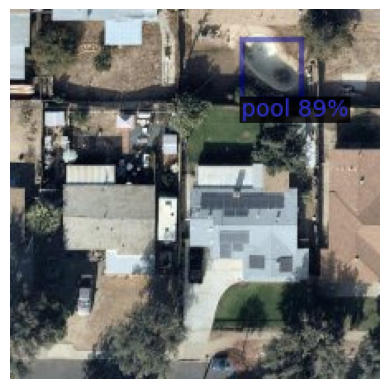

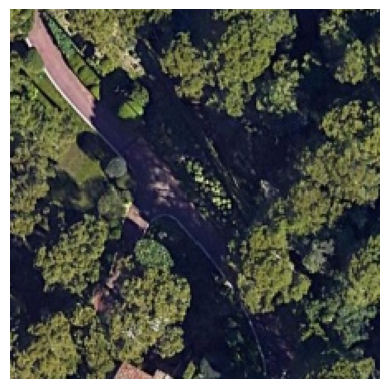

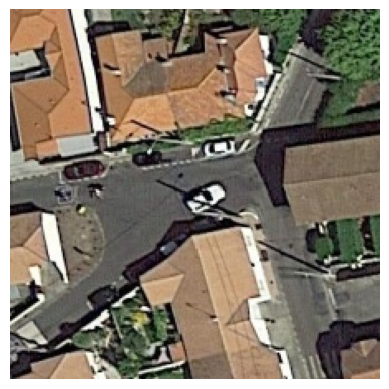

In [13]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts2 = parse_dir_xml("Images/pool_dataset_extended/testing/labels/")
dataset_dicts2
for d in random.sample(dataset_dicts2, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=pool_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print(d["file_name"])
    cv2_imshow(out.get_image()[:, :, ::-1], True)


{'instances': Instances(num_instances=2, image_height=224, image_width=224, fields=[pred_boxes: Boxes(tensor([[102.8094, 140.5277, 134.4141, 177.2000],
        [ 74.5536, 149.2690, 107.0023, 189.5042]], device='cuda:0')), scores: tensor([0.9412, 0.9396], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])}
{'instances': Instances(num_instances=0, image_height=224, image_width=224, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}
{'instances': Instances(num_instances=2, image_height=224, image_width=224, fields=[pred_boxes: Boxes(tensor([[113.3114, 100.0618, 145.7619, 136.1190],
        [ 75.7403,   3.7834, 111.4601,  34.8818]], device='cuda:0')), scores: tensor([0.9690, 0.9527], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])}
{'instances': Instances(num_instances=0, image_height=224, image_width=224, fields=[pred_boxes: Boxes(tensor([

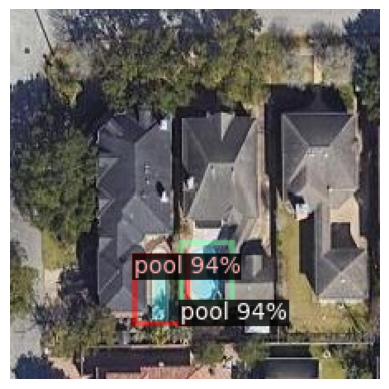

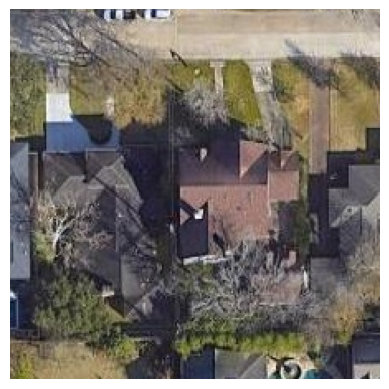

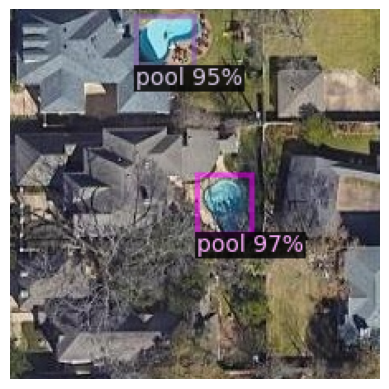

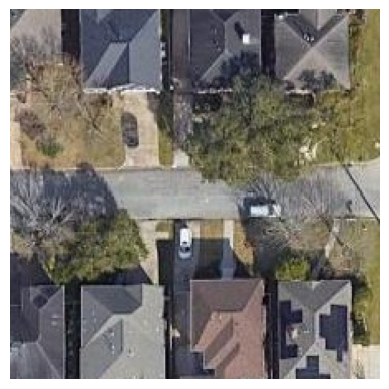

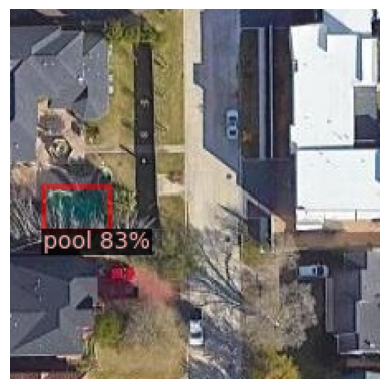

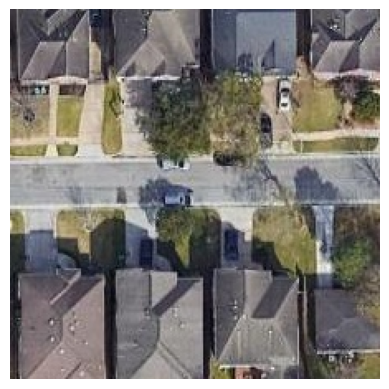

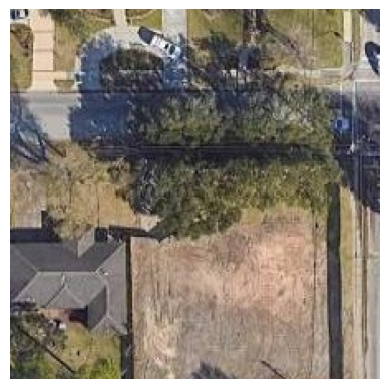

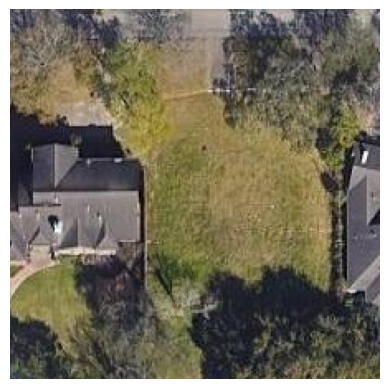

In [90]:
def display_inference_on_unknown_dataset():
    for i in range(0,8):
        im = cv2.imread(f"Images/pool_dataset/testing/image_cropped2/image_houston_x{random.randint(0,20)}_y{random.randint(0,30)}.jpg")
        output = predictor(im)
        print(output)

        v = Visualizer(im,
                metadata=pool_metadata, 
                scale=1, 
                instance_mode=ColorMode.IMAGE # remove the colors of unsegmented pixels. This option is only available for segmentation models
        )
        out = v.draw_instance_predictions(output["instances"].to("cpu"))
        cv2_imshow(out.get_image()[:,:, ::-1])

display_inference_on_unknown_dataset()


In [16]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("pool_testing", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "pool_testing")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[11/17 13:27:45 d2.evaluation.coco_evaluation]: Trying to convert 'pool_testing' to COCO format ...
WARNING [11/17 13:27:45 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/pool_testing_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[11/17 13:27:45 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    pool    | 851          |
|            |              |
[11/17 13:27:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/17 13:27:45 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/17 13:27:45 d2.data.common]: Serializing 1301 elements to byte tensors and concatenating them all ...
[11/17 13:27:45 d2.data.common]: Serialized dataset takes 0.25 MiB
[11/17 13:27:45 d2.